In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import io
import bson                       # this is installed with the pymongo package
import matplotlib.pyplot as plt
from skimage.data import imread   # or, whatever image library you prefer
import multiprocessing as mp      # will come in handy due to the size of the data
import csv
import tensorflow as tf

category_data=pd.read_csv("../input/category_names.csv")

input_bson_filename = '../input/train_example.bson'
output_tfrecords_filename = '../output/train_example.tfrecords'

# Explore the category names

In [2]:
print("Total categories are:", len(category_data))

def concat_category_names(row):
    return "|".join([row['category_level1'],row['category_level2'],row['category_level3']])

category_data['category_name'] = category_data.apply(concat_category_names, axis=1)

category_names_df = category_data[['category_id', 'category_name']]
category_names_dict = category_names_df.set_index('category_id').T.to_dict('list')
category_names_dict[1000021794]

Total categories are: 5270


['ABONNEMENT / SERVICES|CARTE PREPAYEE|CARTE PREPAYEE MULTIMEDIA']

# Load the train_example data

In [3]:
# Simple data processing
data = bson.decode_file_iter(open(input_bson_filename, 'rb'))

0 ['TELEPHONIE - GPS|ACCESSOIRE TELEPHONE|COQUE TELEPHONE - BUMPER TELEPHONE']
image shape: 
(180, 180, 3)


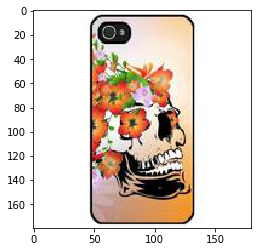

In [4]:
product = next(data)
imgs = product['imgs']
product_id = product['_id']
category_id = product['category_id']
print(product_id, category_names_dict[category_id])
picture=imread(io.BytesIO(imgs[0]['picture']))
plt.imshow(picture)
print("image shape: ")
print(picture.shape)

# Convert bson into tfrecords

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import io
import bson 
import tensorflow as tf
from skimage.data import imread   # or, whatever image library you prefer
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

# helper functions
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

opts = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.ZLIB)


# on my workstation it takes about 5 min per 100k entries, so should finish in about 6h
z = 0 
data = bson.decode_file_iter(open(input_bson_filename, 'rb'))

# for c, d in enumerate(data):
#     n_img = len(d['imgs'])
#     print(n_img)
#     for index in range(n_img):
#         img_raw = d['imgs'][index]['picture']
#         img = imread(io.BytesIO(img_raw))
        

with tf.python_io.TFRecordWriter(output_tfrecords_filename, options=opts) as writer:
    for c, d in enumerate(data):       
        n_img = len(d['imgs'])
        for index in range(n_img):
            img_raw = d['imgs'][index]['picture']
            img = np.array(imread(io.BytesIO(img_raw)))
            height = img.shape[0]
            width = img.shape[1]
            product_id = d['_id']
            category_id = d['category_id'] 
            example = tf.train.Example(features=tf.train.Features(
                feature={
                'height': _int64_feature(height),
                'width': _int64_feature(width),
                'category_id': _int64_feature(category_id),
                'product_id': _int64_feature(product_id),
                'img_raw':_bytes_feature(img.tostring())
            }))
            writer.write(example.SerializeToString())
        z = z + 1
        if z % 10000 == 0:
            print(z)
            break

cat.png
category_names.csv
sample_submission.csv
train_example.bson



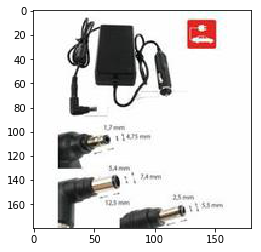

In [5]:
reconstructed_images = []

record_iterator = tf.python_io.tf_record_iterator(path=output_tfrecords_filename, options=opts)

for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example.features.feature['width']
                                .int64_list
                                .value[0])
#     print(height, width)
    img_string = (example.features.feature['img_raw']
                                  .bytes_list
                                  .value[0])
    
    img_1d = np.fromstring(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
            
    reconstructed_images.append(reconstructed_img)
    
plt.imshow(reconstructed_images[2])

In [28]:
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180

def read_and_decode(filename_queue):
    
    opts = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.ZLIB)
    reader = tf.TFRecordReader(options=opts)

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'category_id': tf.FixedLenFeature([], tf.int64),
        'product_id': tf.FixedLenFeature([], tf.int64),
        'img_raw': tf.FixedLenFeature([], tf.string),
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image_raw = tf.decode_raw(features['img_raw'], tf.uint8)    
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    label = tf.cast(features['category_id'], tf.int32)
    
    image_shape = tf.stack([IMAGE_HEIGHT, IMAGE_WIDTH, 3])    
    image = tf.reshape(image_raw, image_shape)
    
    image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, -1), dtype=tf.int32)
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    images, labels = tf.train.shuffle_batch( [resized_image, label],
                                                 batch_size=2,
                                                 capacity=30,seed=1,
                                                 num_threads=2,
                                                 min_after_dequeue=10)
    return images, labels

(180, 180, 3)
(180, 180, 3)
(180, 180, 3)


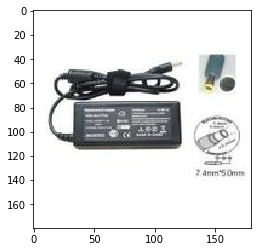

In [32]:
filename_queue = tf.train.string_input_producer([output_tfrecords_filename])
# img, label = read_and_decode(filename_queue)
# img_batch, label_batch = tf.train.shuffle_batch([img, label],
#                                                 batch_size=3, capacity=30,
#                                                 seed = 10,
#                                                 min_after_dequeue=10)

img_batch, label_batch = read_and_decode(filename_queue)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session()  as sess:
    sess.run(init_op)
#     sess.run(tf.global_variables_initializer())
#     sess.run(tf.local_variables_initializer())

    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    # Let's read off 3 batches just for example
    for i in range(3):
    
        imgs, labels = sess.run([img_batch, label_batch])
        print(imgs[0, :, :, :].shape)
        
#         print('current batch')
        
#         # We selected the batch size of two
#         # So we should get two image pairs in each batch
#         # Let's make sure it is random

#         plt.imshow(imgs[0, :, :, :])        
        plt.imshow(imgs[0, :, :, :])
    
    coord.request_stop()
    coord.join(threads)

In [35]:
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180

def read_and_decode(filename_queue):
    
    opts = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.ZLIB)
    reader = tf.TFRecordReader(options=opts)

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'category_id': tf.FixedLenFeature([], tf.int64),
        'product_id': tf.FixedLenFeature([], tf.int64),
        'img_raw': tf.FixedLenFeature([], tf.string),
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image_raw = tf.decode_raw(features['img_raw'], tf.uint8)    
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    label = tf.cast(features['category_id'], tf.int32)
    
    image_shape = tf.stack([IMAGE_HEIGHT, IMAGE_WIDTH, 3])    
    image = tf.reshape(image_raw, image_shape)
    return image, label


filename_queue = tf.train.string_input_producer([output_tfrecords_filename])

img, label = read_and_decode(filename_queue)

# 使用shuffle_batch可以随机打乱输入
img_batch, label_batch = tf.train.shuffle_batch([img, label],
                                                batch_size=3, capacity=30, seed=1,
                                                min_after_dequeue=10)

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
with tf.Session() as sess:
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    for i in range(3):
        val, l= sess.run([img_batch, label_batch])
        #我们也可以根据需要对val， l进行处理
        #l = to_categorical(l, 12) 
        print(val.shape, l)
        
    coord.request_stop()
    coord.join(threads)

(3, 180, 180, 3) [1000018290 1000004141 1000010653]
(3, 180, 180, 3) [1000004079 1000010961 1000004079]
(3, 180, 180, 3) [1000010961 1000005744 1000010961]
